### Exploratory Data Analysis
### For this analysis, you are provided with a large data set consisting of hotel reviews (text fields for positive and negative comments) and details about the stay (hotel location, time & length of stay, etc). Your target column of interest is Reviewer_Score that encodes positive sentiment as 1 and negative as 0.
### First, let's load the data and understand what we are working with.

Perform EDA on the data and mention 3-4 observations from which you can draw actionable insights. In your EDA, you may consider creating a data dictionary, basic statistical analysis, data visualizations, data cleaning and preprocessing to prepare the data for modeling.

### Preprocessing
Next, the text data needs to be processed for modelling.

Split the data into train and test sets and transform the positive and negative review columns using a CountVectorizer. Consider the following:
What tokenizer and text cleaning steps do you include?
Using the vectorizer, maximize the number of features at 500 and make sure that tokens used <10 times are dropped from the vocabulary.
This process may be done on the positive and negative review columns separately and then the resulting arrays merged with the original numeric features to form the final train and test data frames ready for modelling. In your column names, make sure you mark which words are coming from the positive vs negative reviews (you can use a prefix such as pos_ and neg_).

### Modelling
As the data is now ready for modelling, we will be creating two separate models with optimization and evaluation of each.

Fit a logistic regression model on the data and analyze the test and train accuracy. Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1). Similarly, find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0). What actionable insights can you draw from these?

Using a pipeline, combine PCA with a decision tree classifier.

Optimize at least 3 hyperparameters including the maximum tree depth and the minimum number of data points required on each leaf node.
You can use 20 principle components.
The best parameters should be found using 5-fold cross validation.
Contrast the best results here with the logistic regression model and provide any insights that you may draw from the results.

For your best performing model, conduct a more in-depth evaluation by analyzing the confusion matrix and commenting on the model errors and metrics such as precision and recall.
Requirements
Please submit your Jupyter notebook which should include commented code and extensive markdown cells explaining your process and insights. Make sure to add a table of contents, introduction, proper section headers and a conclusion section. Your communication in the markdown cells and the code cell outputs should allow anyone to understand your process and findings without the need to read the code.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from warnings import filterwarnings
filterwarnings(action='ignore')

### FUNCTIONS

In [4]:

def has_special_chars(string):
    return not string.isalnum()

df = pd.DataFrame({'col1': ['Hello', 'World!', '123']})

df['has_special_chars'] = df['col1'].apply(has_special_chars)

print(df)

     col1  has_special_chars
0   Hello              False
1  World!               True
2     123              False


### DF check

In [5]:
hotel=pd.read_csv('data/Hotel_Reviews.csv')

In [6]:
# overview of objects

# 2 Objects are positive and negative review content 
# Target Variables
#### 
hotel.columns

Index(['Unnamed: 0', 'Additional_Number_of_Scoring', 'Average_Score',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'Days_Since_Review', 'Latitude', 'Longitude', 'Day', 'Month', 'Year',
       'Reviewer_Nationality_Australia', 'Reviewer_Nationality_Ireland',
       'Reviewer_Nationality_UAE', 'Reviewer_Nationality_UK',
       'Reviewer_Nationality_USA', 'Reviewer_Nationality_Other',
       'Hotel_Address_Amsterdam', 'Hotel_Address_Barcelona',
       'Hotel_Address_London', 'Hotel_Address_Milan', 'Hotel_Address_Paris',
       'Hotel_Address_Vienna', 'Leisure_Trip', 'Nights_Stayed'],
      dtype='object')

In [7]:
hotel.shape

(515738, 30)

In [8]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Unnamed: 0                                  515738 non-null  int64  
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Average_Score                               515738 non-null  float64
 3   Negative_Review                             515738 non-null  object 
 4   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 5   Total_Number_of_Reviews                     515738 non-null  int64  
 6   Positive_Review                             515738 non-null  object 
 7   Review_Total_Positive_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews_Reviewer_Has_Given  515738 non-null  int64  
 9   Reviewer_Score                              515738 non-null  int64  
 

In [9]:
#hotel.rename(columns={'Unnamed: 0' : 'old_index'}, inplace=True)

In [10]:
# 'Old-index' contains no new information, as expected. Dropping column
#
for rows in hotel['Unnamed: 0']:
    if hotel.index[rows] == hotel['Unnamed: 0'][rows]:
        continue
    else:
        print(rows)
print('done')

# drop columns
#
hotel.drop(columns=['Unnamed: 0'], inplace=True)

done


In [11]:
# Redo columns of df to make it more readable

hotel=hotel[['Reviewer_Score',
 'Nights_Stayed',
 'Positive_Review',
 'Negative_Review',
 'Additional_Number_of_Scoring',
 'Average_Score',
 'Leisure_Trip', 
 'Days_Since_Review',
 'Total_Number_of_Reviews', 
 'Total_Number_of_Reviews_Reviewer_Has_Given',
 'Review_Total_Negative_Word_Counts', 
 'Review_Total_Positive_Word_Counts',
 'Latitude',
 'Longitude',
 'Day',
 'Month',
 'Year',
 'Reviewer_Nationality_Australia',
 'Reviewer_Nationality_Ireland',
 'Reviewer_Nationality_UAE',
 'Reviewer_Nationality_UK',
 'Reviewer_Nationality_USA',
 'Reviewer_Nationality_Other',
 'Hotel_Address_Amsterdam',
 'Hotel_Address_Barcelona',
 'Hotel_Address_London', 
 'Hotel_Address_Milan', 
 'Hotel_Address_Paris',
 'Hotel_Address_Vienna']]


In [12]:
# No null values
hotel.isna().sum().sum()

0

In [13]:
# After removing old index, we can actually take a look a possible duplicates. The old index was a hindrance and it was shown
# in the earlier loop that it matches the index.

hotel.duplicated().value_counts()

False    515199
True        539
Name: count, dtype: int64

In [14]:
# Take a look at a duplicate line
hotel.loc[hotel.Year.eq(2015) & hotel.Day.eq(4) & hotel.Month.eq(8) & hotel.Reviewer_Nationality_UK.eq(1) & hotel.Total_Number_of_Reviews.eq(2515)]	

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
180112,1,1,Very convenient for Gare de Montparnasse,Need better directions from Metro,228,7.9,1,730,2515,9,...,0,1,0,0,0,0,0,0,1,0
180458,1,1,Very convenient for Gare de Montparnasse,Need better directions from Metro,228,7.9,1,730,2515,9,...,0,1,0,0,0,0,0,0,1,0


In [15]:
# Drop the duplicates, keep one copy. Index irrelevant presently, dropping first.

print(hotel.drop_duplicates(keep='first').shape)
hotel.drop_duplicates(keep='first',inplace=True)
print(hotel.shape)

(515199, 29)
(515199, 29)


In [16]:
# Checking duplicates after drop again

hotel.duplicated().value_counts()

False    515199
Name: count, dtype: int64

In [17]:
hotel.head(2)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,0,1,1,0,0,0,0,0
1,0,4,No real complaints the hotel was great great ...,No Negative,194,7.7,1,0,1403,7,...,0,0,0,0,1,0,0,0,0,0


In [18]:
## Checking for special characters
print(hotel.Positive_Review.str.isalnum().value_counts())
print(hotel.Negative_Review.str.isalnum().value_counts())

Positive_Review
False    515186
True         13
Name: count, dtype: int64
Negative_Review
False    515193
True          6
Name: count, dtype: int64


In [19]:
hotel.loc[1].Negative_Review

'No Negative'

In [20]:
# Taking a look at special characters in review columns - may have to revisit this after talking to faculty.

#hotel[hotel.Negative_Review.str.isalnum()==True]

In [21]:
hotel.Positive_Review.str.isalnum().value_counts()

Positive_Review
False    515186
True         13
Name: count, dtype: int64

#### Data Dictionary

In [22]:
# Create a sample DataFrame
data = {
    'type': []
}
df = pd.DataFrame(data)
data_dictionary = pd.DataFrame(index=df.columns, columns=hotel.columns)
# Create a data dictionary


In [23]:
data_dictionary

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
hotel.head(1)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,0,1,1,0,0,0,0,0


In [25]:
data_dictionary

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
is_na=[]
dtype=[]
duplicated=[]

# Establishing columns as needed
for col in hotel.columns:
    data_dictionary[col].type=hotel[col].dtype
    print(hotel[col].dtype)

int64
int64
object
object
int64
float64
int64
int64
int64
int64
int64
int64
float64
float64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64


In [27]:
hotel['Average_Score'].isna().value_counts()

Average_Score
False    515199
Name: count, dtype: int64

In [28]:
data_dictionary=data_dictionary.T

In [29]:
data_dictionary

,type
Reviewer_Score,int64
Nights_Stayed,int64
Positive_Review,object
Negative_Review,object
Additional_Number_of_Scoring,int64
Average_Score,float64
Leisure_Trip,int64
Days_Since_Review,int64
Total_Number_of_Reviews,int64
Total_Number_of_Reviews_Reviewer_Has_Given,int64


In [30]:
data_dictionary

,type
Reviewer_Score,int64
Nights_Stayed,int64
Positive_Review,object
Negative_Review,object
Additional_Number_of_Scoring,int64
Average_Score,float64
Leisure_Trip,int64
Days_Since_Review,int64
Total_Number_of_Reviews,int64
Total_Number_of_Reviews_Reviewer_Has_Given,int64


In [31]:
# data_dictionary=data_dictionary.T

In [32]:
hotel.head(1)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UAE,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,0,1,1,0,0,0,0,0


In [33]:
# Mirror of an index
hotel.old_index

AttributeError: 'DataFrame' object has no attribute 'old_index'

In [ ]:
hotel.duplicated().value_counts()

### EDA

In [35]:
# Create column with continuousl dates for possible use in data exploration and visualization
hotel['Review_Date'] = pd.to_datetime(hotel[['Year', 'Month', 'Day']])
hotel.Review_Date

0        2017-08-03
1        2017-08-03
2        2017-07-31
3        2017-07-31
4        2017-07-24
            ...    
515733   2015-08-30
515734   2015-08-22
515735   2015-08-19
515736   2015-08-17
515737   2015-08-09
Name: Review_Date, Length: 515199, dtype: datetime64[ns]

In [43]:
# Creating Split Dataset for comparison, use down the line as necessary
hotel_pos=hotel[hotel.Reviewer_Score==1]
hotel_neg=hotel[hotel.Reviewer_Score==0]

In [45]:
print('Positive Reviews: ',hotel_pos.shape)
print('Negative Reviews: ',hotel_neg.shape)

Positive Reviews:  (293715, 30)
Negative Reviews:  (221484, 30)


In [49]:
hotel.head(1)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,1,1,0,0,0,0,0,2017-08-03


In [53]:
hotel_pos.head(1)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
7,1,2,Good location Set in a lovely park friendly s...,Apart from the price for the brekfast Everyth...,194,7.7,1,17,1403,1,...,1,0,0,1,0,0,0,0,0,2017-07-17


In [54]:
hotel_neg.head(1)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,1,1,0,0,0,0,0,2017-08-03


<Axes: xlabel='Review_Date'>

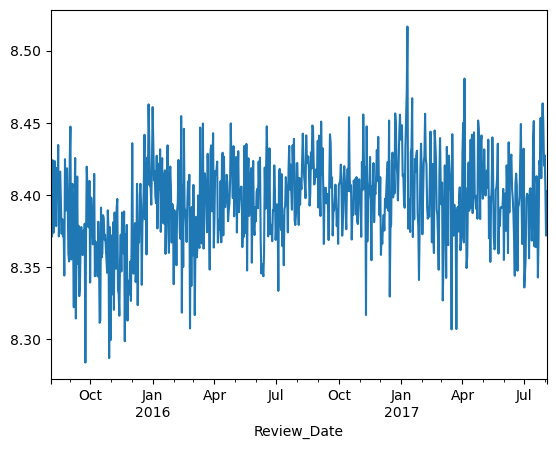

In [48]:
averages=pd.DataFrame
averages=hotel.groupby('Review_Date').Average_Score.mean()

averages.shape
hotel.groupby('Review_Date')['Average_Score'].mean().plot()

In [ ]:
sns.lineplot(x=hotel.Review_Date,y=hotel.groupby('Review_Date')['Average_Score'].mean())

In [ ]:

sns.lineplot(x=hotel['Review_Date'], y=hote())

In [ ]:
#AverageReviews=hotel.groupby('Review_Date').Average_Score.rolling(window=5).mean().to_frame().reset_index()

In [ ]:
#AverageReviews['Average_Score_std']=hotel.groupby('Review_Date').Average_Score.mean()

In [ ]:
#AverageReviews['monthYear']=AverageReviews.Review_Date.dt.month.astype('str')+'-'+AverageReviews.Review_Date.dt.year.astype('str')

 #Create a sample DataFrame
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]})

 #Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(nrows=1, ncols=3)

 #Plot each column on a separate subplot
df['A'].plot(ax=axes[0])
df['B'].plot(ax=axes[1])
df['C'].plot(ax=axes[2])

plt.show()
sns.lineplot(AverageReviews.groupby('monthYear')['Average_Score'].mean())
plt.xticks(rotation=45)
plt.title('Rolling Average Review Score by Month')
plt.show()


<Axes: xlabel='Average_Score', ylabel='Count'>

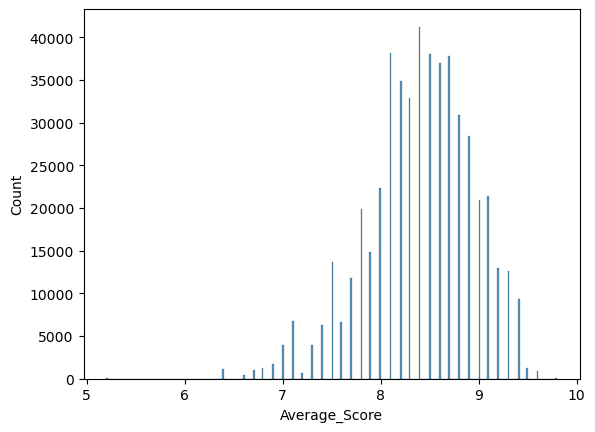

In [74]:
sns.histplot(hotel.Average_Score)

In [75]:
plt.figure(figsize=(8,8))
sns.lineplot(x=AverageReviews.Review_Date,y=AverageReviews.Average_Score)
#plt.ylim(8.2,8.6)

NameError: name 'AverageReviews' is not defined

<Figure size 800x800 with 0 Axes>

In [76]:
#AverageReviews.head(1)

NameError: name 'AverageReviews' is not defined

In [77]:
#AverageReviews['smoothed_value'] = AverageReviews['Average_Score'].rolling(window=5).mean()
#AverageReviews.head(4)

NameError: name 'AverageReviews' is not defined

In [78]:
#AverageReviews.info()

NameError: name 'AverageReviews' is not defined

In [79]:
hotel.head(1)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,1,1,0,0,0,0,0,2017-08-03


In [80]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515199 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Reviewer_Score                              515199 non-null  int64         
 1   Nights_Stayed                               515199 non-null  int64         
 2   Positive_Review                             515199 non-null  object        
 3   Negative_Review                             515199 non-null  object        
 4   Additional_Number_of_Scoring                515199 non-null  int64         
 5   Average_Score                               515199 non-null  float64       
 6   Leisure_Trip                                515199 non-null  int64         
 7   Days_Since_Review                           515199 non-null  int64         
 8   Total_Number_of_Reviews                     515199 non-null  int64         
 9 

In [81]:
fig, ax = plt.subplots(nrows=2, ncol=1)
plt.subplot(111)
sns.lineplot(x=hotel.Nights_Stayed,y=hotel.Average_Score)

plt.subplot(212)
sns.histplot(hotel.Nights_Stayed)


AttributeError: Figure.set() got an unexpected keyword argument 'ncol'

In [ ]:
sns.scatterplot(x=AverageReviews.Review_Date,y=AverageReviews.Average_Score)


In [82]:
hotel.Review_Date.unique()

<DatetimeArray>
['2017-08-03 00:00:00', '2017-07-31 00:00:00', '2017-07-24 00:00:00',
 '2017-07-17 00:00:00', '2017-07-09 00:00:00', '2017-07-08 00:00:00',
 '2017-07-07 00:00:00', '2017-07-06 00:00:00', '2017-07-04 00:00:00',
 '2017-07-03 00:00:00',
 ...
 '2017-06-03 00:00:00', '2017-01-05 00:00:00', '2016-09-21 00:00:00',
 '2016-09-14 00:00:00', '2017-05-12 00:00:00', '2017-07-28 00:00:00',
 '2017-07-23 00:00:00', '2017-07-27 00:00:00', '2017-04-29 00:00:00',
 '2017-07-15 00:00:00']
Length: 731, dtype: datetime64[ns]

In [83]:
AverageReviews.to_frame().info()

NameError: name 'AverageReviews' is not defined

In [84]:
# Trash
#plt.plot(hotel.Review_Date.value(),hotel.groupby('Review_Date').Review_Date.count())

In [85]:
#plt.scatter(hotel.Review_Date,hotel.groupby('Review_Date').Average_Score.mean())

ValueError: x and y must have same first dimension, but have shapes (515199,) and (30,)

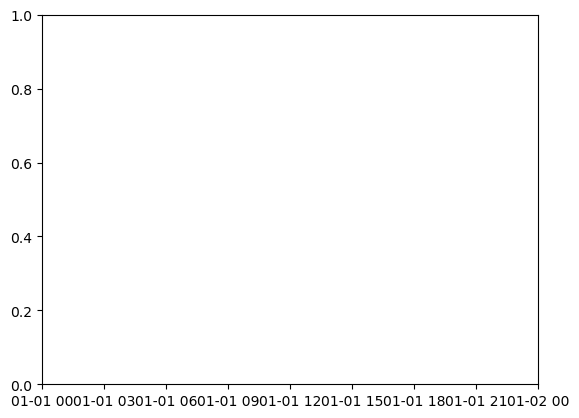

In [86]:
plt.plot(hotel.Review_Date,hotel[hotel.Reviewer_Score==1].count())

In [87]:
sns.lineplot(x=hotel.Review_Date,y=hotel[hotel.Reviewer_Score==1].count())

TypeError: '<' not supported between instances of 'str' and 'int'

In [88]:
mean(data_dictionary)

NameError: name 'mean' is not defined

In [89]:
hotel.describe()

,Reviewer_Score,Nights_Stayed,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
count,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,...,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199
mean,0.570100,2.361750,498.417604,8.397776,0.810070,354.402120,2744.691424,7.164750,18.540711,17.778489,...,0.475752,0.068612,0.365010,0.111043,0.116747,0.509110,0.072209,0.115319,0.075573,2016-08-13 14:20:56.802129152
min,0.000000,1.000000,1.000000,5.200000,0.000000,0.000000,43.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015-08-04 00:00:00
25%,0.000000,1.000000,169.000000,8.100000,1.000000,175.000000,1161.000000,1.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016-02-23 00:00:00
50%,1.000000,2.000000,342.000000,8.400000,1.000000,353.000000,2134.000000,3.000000,9.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2016-08-15 00:00:00
75%,1.000000,3.000000,660.000000,8.800000,1.000000,527.000000,3633.000000,8.000000,23.000000,22.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2017-02-09 00:00:00
max,1.000000,31.000000,2682.000000,9.800000,1.000000,730.000000,16670.000000,355.000000,408.000000,395.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2017-08-03 00:00:00
std,0.495062,1.646734,500.673193,0.547947,0.392246,208.909135,2318.112418,11.039315,29.693602,21.804665,...,0.499412,0.252794,0.481434,0.314185,0.321119,0.499917,0.258834,0.319406,0.264314,NaN


In [90]:
hotel.Review_Total_Positive_Word_Counts

0          11
1         105
2          21
3          26
4           8
         ... 
515733      2
515734     11
515735      0
515736     25
515737      6
Name: Review_Total_Positive_Word_Counts, Length: 515199, dtype: int64

In [110]:
# positive word count per negative review
print('Number of Words in Negative Reviews: ',hotel.Review_Total_Negative_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))
print('Number of Words in Positive Reviews: ',hotel.Review_Total_Positive_Word_Counts.sum()/(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))
# negative word count per negative review

Number of Words in Negative Reviews:  43.127973126726985
Number of Words in Positive Reviews:  31.184856067957032


In [111]:
(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count())/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count())

1.3261228802080511

In [112]:
hotel.Review_Date

0        2017-08-03
1        2017-08-03
2        2017-07-31
3        2017-07-31
4        2017-07-24
            ...    
515733   2015-08-30
515734   2015-08-22
515735   2015-08-19
515736   2015-08-17
515737   2015-08-09
Name: Review_Date, Length: 515199, dtype: datetime64[ns]

In [113]:
# Convert dates into continuous date column for plotting purposes

hotel['Review_Date'] = pd.to_datetime(hotel[['Year', 'Month', 'Day']])
hotel.Review_Date

0        2017-08-03
1        2017-08-03
2        2017-07-31
3        2017-07-31
4        2017-07-24
            ...    
515733   2015-08-30
515734   2015-08-22
515735   2015-08-19
515736   2015-08-17
515737   2015-08-09
Name: Review_Date, Length: 515199, dtype: datetime64[ns]

In [114]:
hotel.shape

(515199, 30)

In [116]:
#hotel[hotel.Reviewer_Score==]

Reviewer_Score
1    293715
0    221484
Name: count, dtype: int64


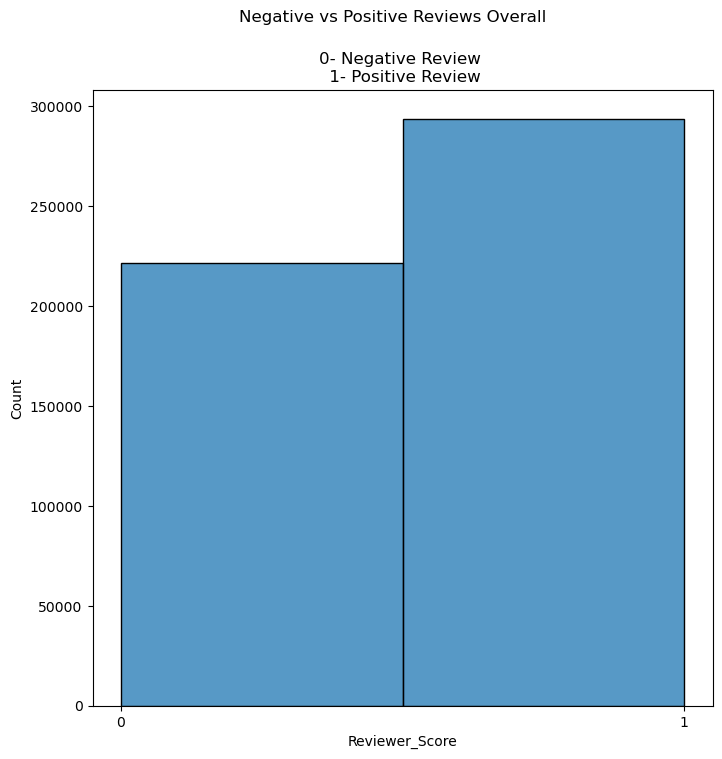

In [118]:
print(hotel.Reviewer_Score.value_counts())
plt.figure(figsize=(8,8))
sns.histplot(hotel.Reviewer_Score, bins=2)
plt.xticks(np.arange(0, 1.1, step=1))
plt.suptitle('Negative vs Positive Reviews Overall')
plt.title('0- Negative Review \n 1- Positive Review')
plt.show()

In [119]:
print('Positive Review: ',(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))
print('Negative Review: ',(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))
(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count())/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count())

Positive Review:  293715
Negative Review:  221484


1.3261228802080511

Pretty simple here - generally positive reviews.

<Axes: >

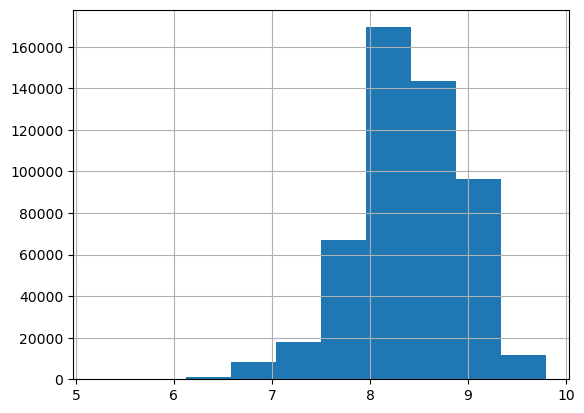

In [99]:
hotel.Average_Score.hist()

In [100]:
hotel.head(3)

,Reviewer_Score,Nights_Stayed,Positive_Review,Negative_Review,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
0,0,6,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,194,7.7,1,0,1403,7,...,0,0,1,1,0,0,0,0,0,2017-08-03
1,0,4,No real complaints the hotel was great great ...,No Negative,194,7.7,1,0,1403,7,...,0,0,0,1,0,0,0,0,0,2017-08-03
2,0,3,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,194,7.7,1,3,1403,9,...,0,0,0,1,0,0,0,0,0,2017-07-31


In [101]:
plt.figure(figsize=(8,8))
sns.hist()

AttributeError: module 'seaborn' has no attribute 'hist'

<Figure size 800x800 with 0 Axes>

In [102]:
plt.scatter(Nights_Stayed,)

NameError: name 'Nights_Stayed' is not defined

<Axes: >

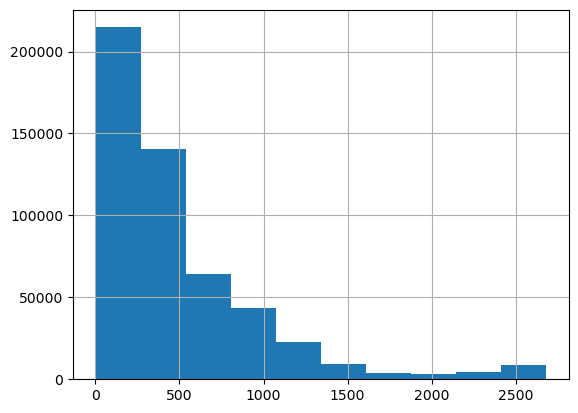

In [103]:
plt.subplot(111)
hotel.Additional_Number_of_Scoring.hist()

18.54071145324428
9552156


<Axes: >

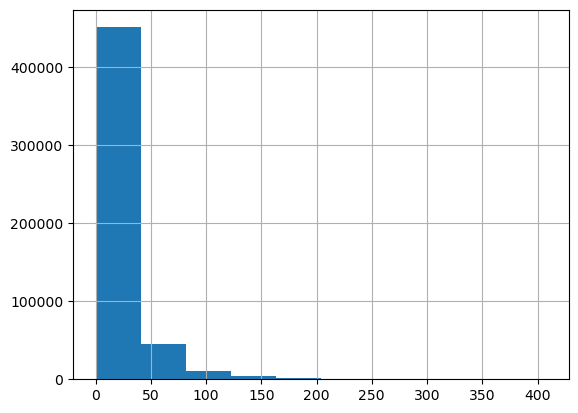

In [104]:
print(hotel.Review_Total_Negative_Word_Counts.mean())
print(hotel.Review_Total_Negative_Word_Counts.sum())
hotel.Review_Total_Negative_Word_Counts.hist()

17.77848947688175
9159460


<Axes: >

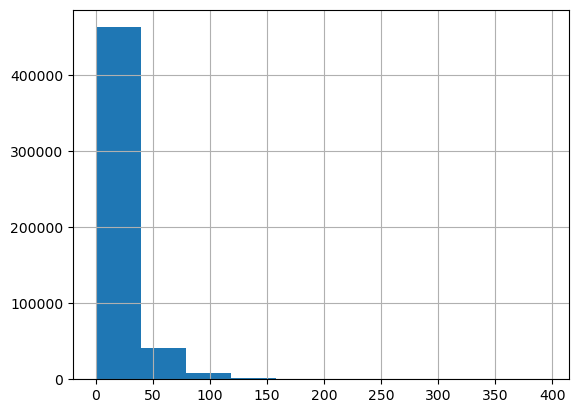

In [105]:
print(hotel.Review_Total_Positive_Word_Counts.mean())
print(hotel.Review_Total_Positive_Word_Counts.sum())
hotel.Review_Total_Positive_Word_Counts.hist()

In [106]:
hotel.describe()

,Reviewer_Score,Nights_Stayed,Additional_Number_of_Scoring,Average_Score,Leisure_Trip,Days_Since_Review,Total_Number_of_Reviews,Total_Number_of_Reviews_Reviewer_Has_Given,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,...,Reviewer_Nationality_UK,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Review_Date
count,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,...,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199.000000,515199
mean,0.570100,2.361750,498.417604,8.397776,0.810070,354.402120,2744.691424,7.164750,18.540711,17.778489,...,0.475752,0.068612,0.365010,0.111043,0.116747,0.509110,0.072209,0.115319,0.075573,2016-08-13 14:20:56.802129152
min,0.000000,1.000000,1.000000,5.200000,0.000000,0.000000,43.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015-08-04 00:00:00
25%,0.000000,1.000000,169.000000,8.100000,1.000000,175.000000,1161.000000,1.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016-02-23 00:00:00
50%,1.000000,2.000000,342.000000,8.400000,1.000000,353.000000,2134.000000,3.000000,9.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2016-08-15 00:00:00
75%,1.000000,3.000000,660.000000,8.800000,1.000000,527.000000,3633.000000,8.000000,23.000000,22.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2017-02-09 00:00:00
max,1.000000,31.000000,2682.000000,9.800000,1.000000,730.000000,16670.000000,355.000000,408.000000,395.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2017-08-03 00:00:00
std,0.495062,1.646734,500.673193,0.547947,0.392246,208.909135,2318.112418,11.039315,29.693602,21.804665,...,0.499412,0.252794,0.481434,0.314185,0.321119,0.499917,0.258834,0.319406,0.264314,NaN


In [107]:
min(hotel.Average_Score)
max(hotel.Average_Score)

9.8

In [108]:
sns.histplot(hotel.Average_Score)
plt.xlim(4,11)plt.show()


SyntaxError: invalid syntax (811814420.py, line 2)

In [109]:
for x in hotel.columns:
    hotel[x].hist()

ConversionError: Failed to convert value(s) to axis units: array(['2017-08-03T00:00:00.000000000', '2017-08-03T00:00:00.000000000',
       '2017-07-31T00:00:00.000000000', ...,
       '2015-08-19T00:00:00.000000000', '2015-08-17T00:00:00.000000000',
       '2015-08-09T00:00:00.000000000'], dtype='datetime64[ns]')

Error in callback <function _draw_all_if_interactive at 0x0000022258AC5EE0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000022200C29A80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
hotel.shape

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
hotel.head(2)

### Question 2: Preprocessing

In [ ]:
## Review of avaialble basic df for use
# hotel - full set with dummies
# hotel_pos - positive reviews with dummies
# hotel_neg - negative reviews with dummies
# hotel_nd - full no dummies
# hotel_nd_nreviews - no dummies no reviews

Split the data into train and test sets and transform the positive and negative review columns using a CountVectorizer. Consider the following:
What tokenizer and text cleaning steps do you include?
Using the vectorizer, maximize the number of features at 500 and make sure that tokens used <10 times are dropped from the vocabulary.
This process may be done on the positive and negative review columns separately and then the resulting arrays merged with the original numeric features to form the final train and test data frames ready for modelling. In your column names, make sure you mark which words are coming from the positive vs negative reviews (you can use a prefix such as pos_ and neg_).

<div class="alert alert-block alert-success">
<b>Up to you:</b><p style="color:black;"><b></b><br>
Split the data into train and test sets and transform the positive and negative review columns using a CountVectorizer. Consider the following: <br>
- What tokenizer and text cleaning steps do you include?<br>
- Using the vectorizer, maximize the number of features at 500 and make sure that tokens used <10 times are dropped from the vocabulary.
    
<p style="color:red;">This process may be done on the positive and negative review columns separately and then the resulting arrays merged with the original numeric features to form the final train and test data frames ready for modelling. In your column names, make sure you mark which words are coming from the positive vs negative reviews (you can use a prefix such as pos_ and neg_).
</b></p></div>

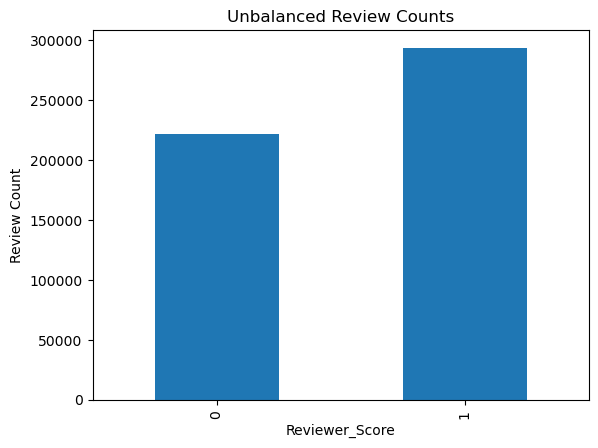

In [66]:
hotel.groupby('Reviewer_Score').Reviewer_Score.count().plot(kind='bar')
plt.ylabel('Review Count')
plt.title('Unbalanced Review Counts')
plt.show()

In [120]:
print('Positive Review: ',(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count()))
print('Negative Review: ',(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count()))
(hotel[hotel.Reviewer_Score==1].Reviewer_Score.count())/(hotel[hotel.Reviewer_Score==0].Reviewer_Score.count())

Positive Review:  293715
Negative Review:  221484


1.3261228802080511